In [115]:
# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()


import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

mode = 'train'


In [95]:
num_epochs = 300 #5000
batch_size = 50
learning_rate = 1e-4 #1e-4
decay_rate = 1e-3 # 1e-1

latent_dim = 2*2*2
epsilon_mean = 1.0
epsilon_std = 1e-2

In [96]:
output = np.load("/Users/dongxiaofeng/Documents/GitHub/zeldo/Zeldotest.np.npy")
output = (output - output.min() )/(output.max() - output.min())

swe_train = output[0:800,:,:]
swe_valid = output[800:1000,:,:]

swe_train = swe_train.reshape(800,64,64,1)
swe_valid = swe_valid.reshape(200,64,64,1)

# # Visualize transformations
# plt.figure()
# plt.imshow(swe_train[0].reshape(64,64))
# plt.show()

# plt.figure()
# plt.imshow(swe_train[1].reshape(64,64))
# plt.show()

# plt.figure()
# plt.imshow(swe_train[2].reshape(64,64))
# plt.show()
# exit()

# Shuffle
swe_train_data = np.copy(swe_train)
swe_valid_data = np.copy(swe_valid)

np.random.shuffle(swe_train_data)
np.random.shuffle(swe_valid_data)


def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )



In [97]:
def sampling(args):
    epsilon_mean = 0.1
    epsilon_std = 1e-4
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim), mean=epsilon_mean, stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [98]:
print(swe_valid.shape)


(200, 64, 64, 1)


In [99]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
     Arguments
        args (tensor): mean and log of variance of Q(z|X)
     Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim), mean=epsilon_mean, stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [100]:
    ## Encoder
    encoder_inputs = Input(shape=(64,64,1),name='Field')
    # Encode   
    x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(encoder_inputs)
    enc_l2 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

    x = Conv2D(25,kernel_size=(3,3),activation='relu',padding='same')(enc_l2)
    enc_l3 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

    x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(enc_l3)
    enc_l4 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

    x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(enc_l4)
    enc_l5 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

    x = Conv2D(10,kernel_size=(3,3),activation=None,padding='same')(enc_l5)
    encoded = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

    x = Flatten()(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 64, 64, 30)   300         Field[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 32, 32, 30)   0           conv2d_49[0][0]                  
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 32, 32, 25)   6775        max_pooling2d_25[0][0]           
____________________________________________________________________________________________

In [101]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(8)(latent_inputs)
x = Reshape((2, 2, 2))(x)
       
x = Conv2D(2,kernel_size=(3,3),activation=None,padding='same')(x)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(25,kernel_size=(3,3),activation='relu',padding='same')(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

decoded = Conv2D(1,kernel_size=(3,3),activation=None,padding='same')(dec_l5)
decoder = Model(inputs=latent_inputs,outputs=decoded)
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
#outputs = decoder(encoder(encoder_inputs))
# vae = Model(encoder_inputs, outputs, name='vae')

plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 8)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
reshape_4 (Reshape)          (None, 2, 2, 2)           0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 2, 2, 2)           38        
_________________________________________________________________
up_sampling2d_20 (UpSampling (None, 4, 4, 2)           0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 4, 4, 15)          285       
_________________________________________________________________
up_sampling2d_21 (UpSampling (None, 8, 8, 15)          0   

In [102]:
## Autoencoder

# instantiate VAE model
# ae_outputs = decoder(encoder(inputs)[2])
ae_outputs = decoder(encoder(encoder_inputs))
model = Model(inputs=encoder_inputs,outputs=ae_outputs,name='VAE')


In [68]:
!pip install pydot
!pip install graphviz

import pydot

In [103]:
import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy, mse

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
lrate = 0.001
weights_filepath = '/Users/dongxiaofeng/Documents/GitHub/zeldo/Zeldotest.h'
mode = 'test' # train, test
num_latent = 8

In [104]:
def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
        SS_res =  K.sum(K.square( y_true-y_pred )) 
        SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
        return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [105]:
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
reconstruction_loss = mse(K.flatten(encoder_inputs), K.flatten(ae_outputs))
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
model.add_loss(vae_loss)
model.compile(optimizer=my_adam,metrics=[coeff_determination])
model.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 18246       Field[0][0]                      
__________________________________________________________________________________________________
model_4 (Model)                 (None, 64, 64, 1)    14691       encoder[1][0]                    
                                                                 encoder[1][1]                    
                                                                 encoder[1][2]                    
________________________________________________________________________________________________

In [106]:

if mode == 'train':
    # train the autoencoder
    hist = model.fit(swe_train_data, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)
    model.save_weights('vae_cnn')


In [80]:
if mode == 'train':
##        checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
        earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
        callbacks_list = earlystopping ##
##        callbacks_list = [checkpoint,earlystopping]
        train_history = model.fit(x=swe_train_data, y=swe_train_data, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_split=0.1)

        # model.load_weights(weights_filepath)

        # Encode the training data to generate time-series information
        encoded_t = K.eval(encoder(swe_train[:,:,:,:].astype('float32')))[0].numpy()
        encoded_v = K.eval(encoder(swe_valid[:,:,:,:].astype('float32')))[0].numpy()

        encoded_t = encoded_t.reshape(900,num_latent)
        encoded_v = encoded_v.reshape(100,num_latent)

        plt.figure()
        plt.plot(encoded_t[0:10,0],label='Dimension 1')
        plt.plot(encoded_t[0:10,1],label='Dimension 2')
        plt.legend()
        plt.show()

        encoded = np.concatenate((encoded_t,encoded_v),axis=0)
        np.save('VAE_Coefficient_Training_Data.npy',encoded)


In [107]:
if mode == 'train':
     fig1 = plt.figure()
     plt.plot(hist.history['loss'],'r')
     plt.plot(hist.history['val_loss'])

In [108]:
model.load_weights('vae_cnn')

# Check for validation
for time in range(0,10):
    recoded = model.predict(swe_valid[time:time+1,:,:,:])
    true = preproc.inverse_transform(swe_valid[time:time+1,:,:,:].reshape(1,4096)).reshape(64,64)
    recoded = preproc.inverse_transform(recoded.reshape(1,4096)).reshape(64,64)

    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(6,6))
    cs1 = ax[0].imshow(true,label='input')
    cs2 = ax[1].imshow(recoded,label='decoded')

    for i in range(2):
        ax[i].set_xlabel('x')
        ax[i].set_ylabel('y')
            
    fig.colorbar(cs1,ax=ax[0],fraction=0.046, pad=0.04)
    fig.colorbar(cs2,ax=ax[1],fraction=0.046, pad=0.04)
    ax[0].set_title(r'True $q_1$')
    ax[1].set_title(r'Reconstructed $q_1$')
    plt.subplots_adjust(wspace=0.5,hspace=-0.3)
    plt.tight_layout()
    plt.show()


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x141d9be48> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x141d9fe48>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x141f50198> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x141f507b8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x129bcfe10> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x141f5fc88>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1447ad4a8> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x129e2f860>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x144795208> and <tensorf

ValueError: Shapes (25,) and (30,) are incompatible

In [116]:
model.load_weights('vae_cnn')

#recoded = model.predict(swe_valid[time:time+1,:,:,:])

OSError: Unable to open file (file signature not found)

In [110]:
generator = model.predict(swe_valid[0:2])

In [111]:
print(generator.shape)

(2, 64, 64, 1)


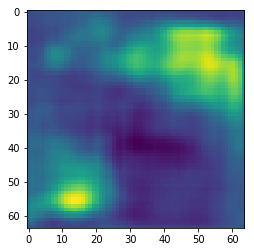

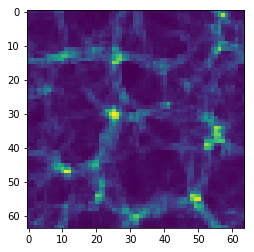

In [112]:
plt.imshow(generator[1,:,:,0])
plt.figure()
plt.imshow(swe_valid[1,:,:,0])

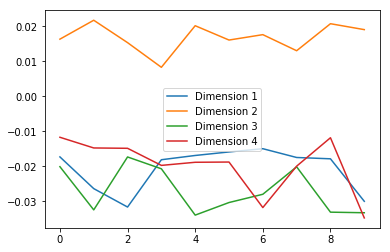

In [114]:


encoded_t_arr = K.eval(encoder(swe_train[:,:,:,:].astype('float32')))[0]
encoded_v_arr = K.eval(encoder(swe_valid[:,:,:,:].astype('float32')))[0]
encoded_t = encoded_t_arr
encoded_v = encoded_v_arr



plt.figure()
plt.plot(encoded_t[0:10,0],label='Dimension 1')
plt.plot(encoded_t[0:10,1],label='Dimension 2')
plt.plot(encoded_t[0:10,2],label='Dimension 3')
plt.plot(encoded_t[0:10,3],label='Dimension 4')
plt.legend()
plt.show()

encoded = np.concatenate((encoded_t,encoded_v),axis=0)
np.save('VAE_Coefficient_Training_Data.npy',encoded)
